In [1]:
import pandas as pd

In [2]:
mergedData = '..\\data\\mergedData\\merged_df_03.csv'
df = pd.read_csv(mergedData)
df.head()

C:\Users\csang\AppData\Local\Temp\ipykernel_46896\2518020550.py:2: DtypeWarning: Columns (1,7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(mergedData)


,Unnamed: 0,Report_No,Reported_Date,Reported_Time,From_Date,Address,City,DVFlag,Involvement,Firearm Used Flag,Location,Offense_Description,lon,lat,dist_id
0,0,150015427,03/06/2015,0:02,03/06/2015,BROADWAY and WESTPORT RD,KANSAS CITY,U,VIC,N,POINT (-94.5767 38.9767),Misc Violation,-94.5767,38.9767,6.0
1,1,150057463,09/08/2015,1:17,09/08/2015,PROSPECT AV and E TRUMAN RD,KANSAS CITY,U,SUS,N,POINT (-94.5516 39.0947),Auto Theft,-94.5516,39.0947,3.0
2,2,150033873,05/19/2015,0:21,05/19/2015,VICTOR ST and WALROND AV,KANSAS CITY,U,VIC,N,POINT (-94.5461 39.0735),Possession/Sale/Dist,-94.5461,39.0735,3.0
3,3,150061779,08/31/2015,10:28,08/31/2015,PASEO and E TRUMAN RD,KANSAS CITY,N,SUS,N,POINT (-89.0251 42.2167),Non Aggravated Assau,-89.0251,42.2167,1.0
4,4,150087307,12/04/2015,2:57,12/04/2015,PASEO and E TRUMAN RD,KANSAS CITY,U,VIC,N,POINT (-94.5645 39.0952),Misc Violation,-94.5645,39.0952,3.0


In [3]:
df['description_length'] = df['Offense_Description'].apply(lambda x: len(str(x).split()))
max_length = df['description_length'].max()

print(f"The maximum number of words in an Offense_Description is: {max_length}")


The maximum number of words in an Offense_Description is: 8


### Group these descriptions based on similarity using TF-IDF vectorization and KMeans clustering

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

offense_descriptions = df['Offense_Description'].dropna()

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, max_length))
X = vectorizer.fit_transform(offense_descriptions)

c:\Users\csang\miniconda3\envs\fhgr\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\csang\miniconda3\envs\fhgr\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\csang\miniconda3\envs\fhgr\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\csang\miniconda3\envs\fhgr\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\csang\m

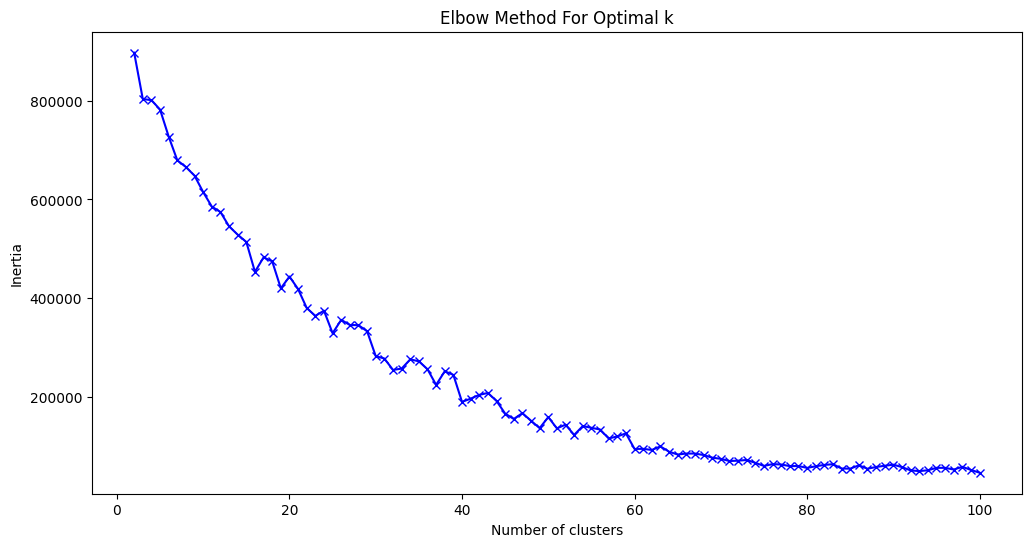

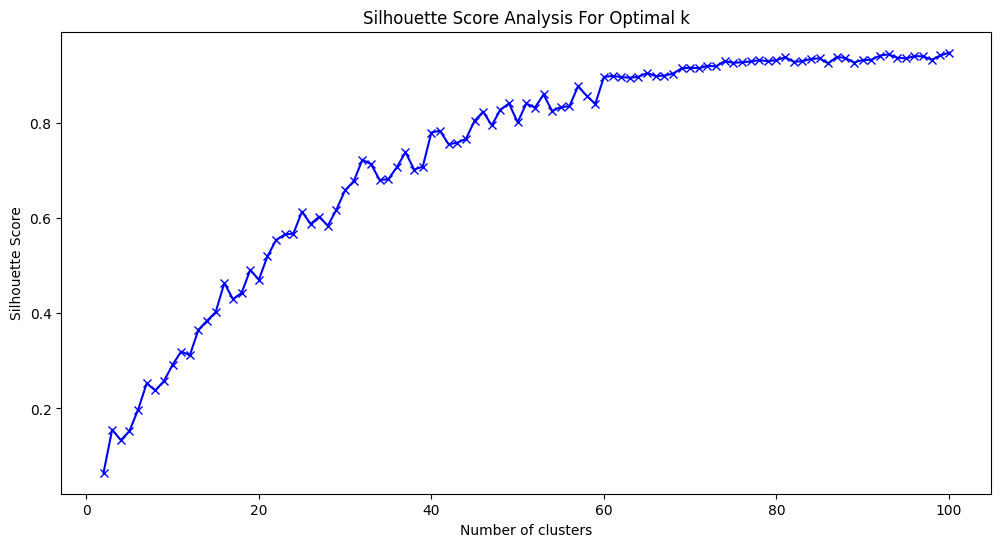

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
import numpy as np

def find_optimal_clusters(X, max_k):
    inertia_values = []
    silhouette_values = []
    k_range = range(2, max_k + 1)

    for k in k_range:
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
        kmeans.fit(X)
        
        inertia_values.append(kmeans.inertia_)
        
        if X.shape[0] < 10000:
            silhouette = silhouette_score(X, kmeans.labels_)
        else:
            sample_indices = np.random.choice(X.shape[0], size=10000, replace=False)
            silhouette = silhouette_score(X[sample_indices], kmeans.labels_[sample_indices])
        
        silhouette_values.append(silhouette)

    plt.figure(figsize=(12, 6))
    plt.plot(k_range, inertia_values, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(k_range, silhouette_values, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score Analysis For Optimal k')
    plt.show()

find_optimal_clusters(X, max_k=100)



In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans

offense_descriptions = df['Offense_Description'].dropna()

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, max_length))
X = vectorizer.fit_transform(offense_descriptions)

n_clusters = 75
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=1000)
df['Offense_Cluster'] = kmeans.fit_predict(X)

df[['Offense_Description', 'Offense_Cluster']].head()

c:\Users\csang\miniconda3\envs\fhgr\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Offense_Description,Offense_Cluster
0,Misc Violation,10
1,Auto Theft,26
2,Possession/Sale/Dist,14
3,Non Aggravated Assau,20
4,Misc Violation,10


In [6]:
import numpy as np

ClusterInfos = []

def get_top_terms_per_cluster(X, cluster_labels, vectorizer, n_terms=5):
    """Return the top n terms for each cluster."""
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()
    cluster_terms = {}
    
    for i in range(n_clusters):
        top_terms = [terms[ind] for ind in order_centroids[i, :n_terms]]
        cluster_terms[i] = top_terms
    
    return cluster_terms
top_terms_per_cluster = get_top_terms_per_cluster(X, kmeans.labels_, vectorizer)

for cluster, terms in top_terms_per_cluster.items():
    print(f"Cluster {cluster}: {', '.join(terms)}")
    ClusterInfos.append(f"Cluster {cluster}: {', '.join(terms)}")

Cluster 0: armed robbery, armed, robbery, felon, family disturbance
Cluster 1: stealing, pickpocket, stealing pickpocket, stealing purse, purse
Cluster 2: violence assault non aggravated, domestic violence assault non, domestic violence assault non aggravated, violence assault non, domestic violence assault
Cluster 3: burglary residence, residence, burglary, withhold property, family offense
Cluster 4: stolen auto, stolen, auto, felon prohibited person, family offense
Cluster 5: property damage, damage, property, leased, leased rented
Cluster 6: auto, theft auto, auto theft auto, stealing auto theft, stealing auto theft auto
Cluster 7: assault non, assault non aggravated, non aggravated, non, aggravated
Cluster 8: non agg, non agg assault, assault dome, agg assault dome, dome
Cluster 9: real, real property, trespass real property, trespass real, trespass
Cluster 10: misc, misc violation, violation, withhold property, exploitation
Cluster 11: aggravated assault, aggravated, assault, fel

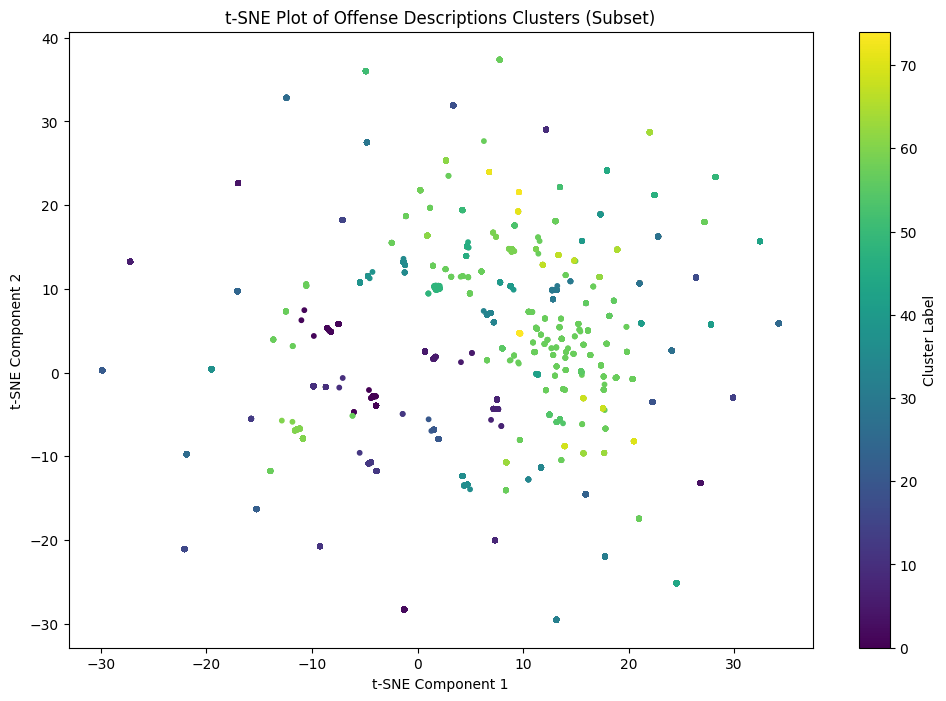

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Since X is large, we can use a random subset of the data to speed up the t-SNE computation
subset_size = 20000  # Choose a subset size to balance performance and visualization quality
random_indices = np.random.choice(X.shape[0], size=subset_size, replace=False)
X_subset = X[random_indices]

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
X_embedded = tsne.fit_transform(X_subset.toarray())

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=df.iloc[random_indices]['Offense_Cluster'], cmap='viridis', s=10)
plt.colorbar(scatter, label='Cluster Label')
plt.title('t-SNE Plot of Offense Descriptions Clusters (Subset)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [8]:
from langchain_groq import ChatGroq
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.exceptions import OutputParserException
import os
from dotenv import load_dotenv

load_dotenv()

def describe_clusters_with_llm(cluster_keywords, model_name="llama-3.1-70b-versatile", temperature=0):
    """
    Uses LangChain with Groq API to describe clusters based on top terms.

    Parameters:
    - cluster_keywords (list): List of strings with each cluster's top terms.
    - model_name (str): The name of the LLM model to use.
    - temperature (float): The temperature setting for the LLM, for controlling randomness.

    Returns:
    - list of dicts: Each dict contains 'Groupname' and 'Description' for the clusters.
    """
    llm = ChatGroq(
        temperature=temperature,
        groq_api_key=os.getenv("GROQ_API_KEY"),
        model_name=model_name
    )
    
    prompt_template = PromptTemplate.from_template(
            """
            Given the following list of clusters with associated keywords, create a JSON response where each cluster is assigned a meaningful 'Groupname' and a corresponding 'Description'. 
            The 'Groupname' should be a concise label that captures the general theme or category of the cluster based only on the keywords provided. 
            The 'Description' should strictly explain the types of incidents, crimes, or activities included in the cluster using only the given keywords, without making assumptions or inventing details. 
            The output should be formatted in valid JSON as an array of objects, where each object contains:
            - 'Groupname': a string representing the concise name for the cluster.
            - 'Description': a string describing the cluster's common themes or activities, derived solely from the provided keywords.

            Here is the list of clusters and keywords:
            
            {cluster_data}

            Do not add any information that is not directly supported by the keywords provided.
            ### VALID JSON (NO PREAMBLE):
            """
    )

    
    chain = prompt_template | llm
    
    try:
        response = chain.invoke({"cluster_data": cluster_keywords})
        json_parser = JsonOutputParser()
        result = json_parser.parse(response.content)
    except OutputParserException:
        raise OutputParserException("Failed to parse the LLM's response.")
    
    return result

In [9]:
descriptions = describe_clusters_with_llm(ClusterInfos)

In [10]:
descriptions

[{'Groupname': 'Armed Robbery',
  'Description': 'Incidents involving armed robbery, felon, and family disturbance.'},
 {'Groupname': 'Theft',
  'Description': 'Incidents involving stealing, pickpocket, and purse theft.'},
 {'Groupname': 'Domestic Violence',
  'Description': 'Incidents involving domestic violence, assault, and non-aggravated violence.'},
 {'Groupname': 'Burglary',
  'Description': 'Incidents involving burglary, residence, and withhold property.'},
 {'Groupname': 'Stolen Auto',
  'Description': 'Incidents involving stolen auto, felon prohibited person, and family offense.'},
 {'Groupname': 'Property Damage',
  'Description': 'Incidents involving property damage, leased, and rented property.'},
 {'Groupname': 'Auto Theft',
  'Description': 'Incidents involving auto theft, theft auto, and stealing auto.'},
 {'Groupname': 'Assault',
  'Description': 'Incidents involving assault, non-aggravated, and non-aggravated assault.'},
 {'Groupname': 'Domestic Assault',
  'Descriptio

In [11]:
cluster_info = {i: {"Groupname": desc["Groupname"], "Description": desc["Description"]} for i, desc in enumerate(descriptions)}

df['Cluster_Name'] = df['Offense_Cluster'].map(lambda x: cluster_info[x]['Groupname'])
df['Cluster_Description'] = df['Offense_Cluster'].map(lambda x: cluster_info[x]['Description'])

df[['Offense_Description', 'Offense_Cluster', 'Cluster_Name', 'Cluster_Description']].head()


,Offense_Description,Offense_Cluster,Cluster_Name,Cluster_Description
0,Misc Violation,10,Miscellaneous Violation,"Incidents involving miscellaneous violation, w..."
1,Auto Theft,26,Auto Theft,"Incidents involving auto theft, theft, and aut..."
2,Possession/Sale/Dist,14,Possession Sale,"Incidents involving possession sale, distribut..."
3,Non Aggravated Assau,20,Assault,"Incidents involving non-aggravated assault, ag..."
4,Misc Violation,10,Miscellaneous Violation,"Incidents involving miscellaneous violation, w..."


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987906 entries, 0 to 987905
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           987906 non-null  int64  
 1   Report_No            987906 non-null  object 
 2   Reported_Date        987906 non-null  object 
 3   Reported_Time        987906 non-null  object 
 4   From_Date            987906 non-null  object 
 5   Address              987906 non-null  object 
 6   City                 987906 non-null  object 
 7   DVFlag               987906 non-null  object 
 8   Involvement          987906 non-null  object 
 9   Firearm Used Flag    987906 non-null  object 
 10  Location             987906 non-null  object 
 11  Offense_Description  987906 non-null  object 
 12  lon                  987906 non-null  float64
 13  lat                  987906 non-null  float64
 14  dist_id              987906 non-null  float64
 15  description_lengt

In [13]:
df.head()

,Unnamed: 0,Report_No,Reported_Date,Reported_Time,From_Date,Address,City,DVFlag,Involvement,Firearm Used Flag,Location,Offense_Description,lon,lat,dist_id,description_length,Offense_Cluster,Cluster_Name,Cluster_Description
0,0,150015427,03/06/2015,0:02,03/06/2015,BROADWAY and WESTPORT RD,KANSAS CITY,U,VIC,N,POINT (-94.5767 38.9767),Misc Violation,-94.5767,38.9767,6.0,2,10,Miscellaneous Violation,"Incidents involving miscellaneous violation, w..."
1,1,150057463,09/08/2015,1:17,09/08/2015,PROSPECT AV and E TRUMAN RD,KANSAS CITY,U,SUS,N,POINT (-94.5516 39.0947),Auto Theft,-94.5516,39.0947,3.0,2,26,Auto Theft,"Incidents involving auto theft, theft, and aut..."
2,2,150033873,05/19/2015,0:21,05/19/2015,VICTOR ST and WALROND AV,KANSAS CITY,U,VIC,N,POINT (-94.5461 39.0735),Possession/Sale/Dist,-94.5461,39.0735,3.0,1,14,Possession Sale,"Incidents involving possession sale, distribut..."
3,3,150061779,08/31/2015,10:28,08/31/2015,PASEO and E TRUMAN RD,KANSAS CITY,N,SUS,N,POINT (-89.0251 42.2167),Non Aggravated Assau,-89.0251,42.2167,1.0,3,20,Assault,"Incidents involving non-aggravated assault, ag..."
4,4,150087307,12/04/2015,2:57,12/04/2015,PASEO and E TRUMAN RD,KANSAS CITY,U,VIC,N,POINT (-94.5645 39.0952),Misc Violation,-94.5645,39.0952,3.0,2,10,Miscellaneous Violation,"Incidents involving miscellaneous violation, w..."


In [14]:
df.to_csv("..\\data\\mergedData\\merged_df_04.csv")